In [3]:
# Terminal / Anaconda Navigator: conda install -c conda-forge gensim
import pickle
from gensim import matutils, models, corpora
import scipy.sparse
import pandas as pd
from gensim.models import LdaMulticore, CoherenceModel

In [4]:
f_data = pd.read_csv('../data/tweets_final.csv')
f_data = f_data.iloc[0:100,:]
f_data.head(3)

,Datetime,Tweet Id,Text,Username
0,2022-06-17 23:59:41+00:00,1537948125628747777,@BitMartExchange To the Moon 💯💵💎\n@galuka156 @...,cozyhomes88
1,2022-06-17 23:59:27+00:00,1537948068431007744,THIS!!!....@metazooxyz with @MrSweMusic1...RIG...,TTJP_1
2,2022-06-17 23:59:02+00:00,1537947961983832066,In #Mars4 #game demo you can free your imagina...,Dubai_community


In [5]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

# Vedi pickle
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(f_data.Text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = f_data.index
data_dtm = data_dtm.iloc[0:10,:]

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
# One of the required inputs is a term-document matrix
tdm = data_dtm.transpose()
tdm.head()

,0,1,2,3,4,5,6,7,8,9
00667,0,0,0,0,0,0,0,0,0,0
01,0,0,0,0,0,0,0,0,0,0
037,0,0,0,0,0,0,0,0,0,0
039bkt0av4,0,0,0,0,0,0,0,0,0,0
043,0,0,0,0,0,0,0,0,0,0


In [7]:
# We're going to put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(data_dtm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [8]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
cv = pickle.load(open("../data/cv_stop.pkl", "rb"))
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

/usr/local/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.18.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
# Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term),
# we need to specify two other parameters as well - the number of topics and the number of passes # Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term),
# we need to specify two other parameters as well - the number of topics and the number of passes
lsi = models.LsiModel(corpus, 3, id2word = id2word)
lsi.print_topics()

[(0,
  '-0.544*"aah" + -0.453*"aaaahhhhh" + -0.450*"aaaaauuugghhhhhh" + -0.374*"abcs" + -0.242*"aaah" + -0.195*"aaaaahhhhhhh" + -0.184*"abject" + -0.104*"ability" + -0.100*"abc" + -0.072*"aaaaah"'),
 (1,
  '-0.656*"aah" + 0.559*"ability" + 0.338*"abcs" + 0.217*"aaaahhhhh" + 0.176*"aaaaahhhhhhh" + -0.146*"aaah" + 0.141*"abc" + 0.112*"aaaaauuugghhhhhh" + 0.106*"aaaaah" + 0.019*"abject"'),
 (2,
  '-0.778*"abc" + -0.347*"ability" + 0.316*"aaaaauuugghhhhhh" + -0.262*"aah" + 0.219*"abcs" + 0.182*"aaaahhhhh" + -0.126*"aaaaahhhhhhh" + -0.074*"aaah" + -0.050*"aaaaah" + -0.024*"abject"')]

In [12]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)]
    return ' '.join(all_nouns)

In [13]:
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns = pd.DataFrame(f_data.Text.apply(nouns))
data_nouns

,Text
0,BitMartExchange Moon 💯💵💎 @ galuka156 @ hoangye...
1,THIS metazooxyz @ MrSweMusic1 NOW DCLMETATIGER...
2,Mars4 game demo imagination buildings rules PL...
3,PROJECT project @ ProjectSeedGame https Projec...
4,@ verasaw project level NFTGaming List https /...
...,...
95,NFT👍🥰 show NFT NodeJS DEFI BLOCKHAIN cryptocur...
96,Blockchain Keys Unlock Murky Metaverse Alison ...
97,Más subas tasa Recesión Mayor inflación / lo q...
98,METAME EU5 facescans https //t.co/QCznV0OFwN


In [14]:
# Create a new document-term matrix using only nouns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns.Text)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
data_dtmn

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,01,043,0jggwas0wy,2421,2kbhcq8xhw,2qejf2scii,2wqubowap3,4pvzxjwgaw,670億円のweb3ゲームファンドをローンチ,6yzvmgmjbk,...,zl7npcn7qt,zwfzskn4ay,zxmgysbojb,édition,ótimo,こうゆうmr,メタバース,的な映像技術が進化していくと思います,私は今後,複合現実
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [17]:
# Let's try topics = 3
lsin = models.LsiModel(corpusn, 3, id2word = id2wordn)
lsin.print_topics()

[(0,
  '0.673*"https" + 0.598*"metaverse" + 0.214*"nft" + 0.178*"nfts" + 0.110*"nftcommunity" + 0.093*"bitcoin" + 0.062*"crypto" + 0.058*"project" + 0.054*"gold" + 0.053*"ethereum"'),
 (1,
  '-0.523*"https" + 0.289*"metaverse" + 0.268*"nfts" + 0.252*"bitcoin" + 0.242*"nft" + 0.222*"gold" + 0.202*"cryptocurrencies" + 0.202*"ethereum" + 0.200*"othereconomy" + 0.200*"otraeconomia"'),
 (2,
  '-0.580*"metaverse" + 0.381*"nft" + 0.254*"https" + 0.245*"nftcommunity" + 0.195*"nfts" + -0.159*"title" + -0.159*"news" + 0.152*"gold" + -0.151*"btc" + 0.143*"ethereum"')]

In [18]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)]
    return ' '.join(nouns_adj)

In [19]:
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns_adj = pd.DataFrame(f_data.Text.apply(nouns_adj))
data_nouns_adj

,Text
0,@ BitMartExchange Moon 💯💵💎 @ galuka156 @ hoang...
1,THIS .... @ metazooxyz @ MrSweMusic1 NOW 🔥🔥🔥🔥🎶...
2,Mars4 game demo imagination craziest buildings...
3,PROJECT big project potential 🔥🔥🔥💚👏 @ ProjectS...
4,@ verasaw project next level NFTGaming metaver...
...,...
95,NFT👍🥰 show NFT java NodeJS metaverse DEFI BLOC...
96,Blockchain Keys Unlock Murky Metaverse Alison ...
97,Más subas tasa Recesión Mayor inflación / lo q...
98,METAME metahuman unrealengine EU5 metaverse fa...


In [22]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(data_nouns_adj.Text)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
data_dtmna

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,01,039bkt0av4,043,0jggwas0wy,10,11,15,2421,2kbhcq8xhw,2qejf2scii,...,zl7npcn7qt,zwfzskn4ay,zxmgysbojb,édition,ótimo,こうゆうmr,メタバース,的な映像技術が進化していくと思います,私は今後,複合現実
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [24]:
# Let's try 3 topics
ldana = models.LsiModel(corpus=corpusna, num_topics=3, id2word=id2wordna)
ldana.print_topics()

[(0,
  '0.819*"https" + 0.323*"nft" + 0.220*"nfts" + 0.142*"nftcommunity" + 0.117*"crypto" + 0.080*"project" + 0.079*"bitcoin" + 0.070*"mintable" + 0.066*"store" + 0.062*"cryptocurrencies"'),
 (1,
  '-0.369*"nft" + 0.364*"https" + -0.317*"nfts" + -0.269*"nftcommunity" + -0.250*"gold" + -0.233*"cryptocurrencies" + -0.229*"ethereum" + -0.222*"othereconomy" + -0.222*"otraeconomia" + -0.214*"bitcoin"'),
 (2,
  '0.400*"mintable" + 0.354*"store" + 0.279*"crypto" + 0.226*"nftcommmunity" + 0.224*"nftnyc" + 0.217*"nftartist" + -0.194*"gold" + 0.192*"flow" + 0.174*"gasless" + -0.169*"ethereum"')]

In [25]:
from gensim import corpora
word2id = dict((k, v) for k, v in cvna.vocabulary_.items())
d = corpora.Dictionary()
d.id2token = id2word
d.token2id = word2id

In [29]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    lsi_model = models.LsiModel(corpus=corpus, num_topics=k, id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=lsi_model, corpus=corpus,dictionary=dictionary, coherence='u_mass')
    return coherence_model_lda.get_coherence()

In [31]:
compute_coherence_values(corpusna,d,2)

-14.03260592496433

In [34]:
import numpy as np
from gensim import models
# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
# Validation sets
model_results = {
                 'Topics': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
        # iterate through number of topics
    for k in topics_range:

                    # get the coherence score for the given parameters
        cv = compute_coherence_values(corpus=corpusna, dictionary=d,
                                                  k=k)
                    # Save the model results
        model_results['Topics'].append(k)
        model_results['Coherence'].append(cv)

In [35]:
model_results

{'Topics': [2, 3, 4, 5, 6, 7, 8, 9],
 'Coherence': [-15.570722621949521,
  -9.6549094887679,
  -12.856685415171091,
  -13.262111859593864,
  -11.5295119816114,
  -11.49279093294388,
  -13.002235746065931,
  -12.699554583133216]}

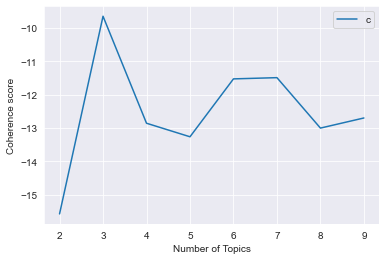

In [36]:
import matplotlib.pyplot as plt
def plot_graph(model_results):
    plt.plot(model_results['Topics'], model_results['Coherence'])
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

plot_graph(model_results)